<a href="https://colab.research.google.com/github/Clizzyvibes/CHLOROGLOBE-SUITABILITY-PROJECT-COVENTRY-UNIVERSITY/blob/main/Chloroglobe_v6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChloroGlobe: A Complete Project Workflow
This notebook documents the entire process of building the ChloroGlobe habitat suitability model, from raw data curation to final map generation and analysis.



## **Part 0: Environment Setup**
`It is a no brainer that we need to setup the environment to begin building, and we call this Part 0 as python starts counting at zero` 😉




### 0.0. Installing and Loading libraries
The necessary libraries for the whole of this project are intalled and loaded in this part.

In [ ]:
# Install necessary Libraries
!pip install pandas geopandas rasterio rioxarray scikit-learn matplotlib seaborn contextily xgboost

# Quick Note: 'contextily' is great for adding basemaps to plots for quick visualization.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Load/Import all required libraries for the project
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay

### 0.1. Mounting drive and extracting the datasets
The necessary libraries for the whole of this project are intalled and loaded in this part.

`Quick Note: I Unzipped the data files from Google Drive to the temporary Colab session for faster access and not to clog up my drive`

In [ ]:
# Mount Google Drive to access project files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzipping the files from GBIF on drive directly to my colabs directory
!unzip '/content/drive/MyDrive/Study x Research/Chloroglobe/Data/0088298-250525065834625.zip' -d gbif

Archive:  /content/drive/MyDrive/Study x Research/Chloroglobe/Data/0088298-250525065834625.zip
  inflating: gbif/rights.txt         
  inflating: gbif/citations.txt      
  inflating: gbif/dataset/017f23ba-bf04-4eb7-a076-04ab2e5de250.xml  
  inflating: gbif/dataset/040c5662-da76-4782-a48e-cdea1892d14c.xml  
  inflating: gbif/dataset/a3f57ea9-fad6-46ca-a1ee-0e47d1073ec0.xml  
  inflating: gbif/dataset/0645ccdb-e001-4ab0-9729-51f1755e007e.xml  
  inflating: gbif/dataset/38b4c89f-584c-41bb-bd8f-cd1def33e92f.xml  
  inflating: gbif/dataset/43027054-3812-4599-b7bc-a01f1df5b071.xml  
  inflating: gbif/dataset/492d63a8-4978-4bc7-acd8-7d0e3ac0e744.xml  
  inflating: gbif/dataset/4ce8e3f9-2546-4af1-b28d-e2eadf05dfd4.xml  
  inflating: gbif/dataset/50c9509d-22c7-4a22-a47d-8c48425ef4a7.xml  
  inflating: gbif/dataset/6ac3f774-d9fb-4796-b3e9-92bf6c81c084.xml  
  inflating: gbif/dataset/7e380070-f762-11e1-a439-00145eb45e9a.xml  
  inflating: gbif/dataset/821cc27a-e3bb-4bc5-ac34-89ada245069d.xml  
 

In [ ]:
# unzipping the files from Worldclim.org on drive directly to my colabs directory
!unzip '/content/drive/MyDrive/Study x Research/Chloroglobe/Data/wc2.1_2.5m_bio.zip' -d current_climate

Archive:  /content/drive/MyDrive/Study x Research/Chloroglobe/Data/wc2.1_2.5m_bio.zip
  inflating: current_climate/wc2.1_2.5m_bio_1.tif  
  inflating: current_climate/wc2.1_2.5m_bio_10.tif  
  inflating: current_climate/wc2.1_2.5m_bio_11.tif  
  inflating: current_climate/wc2.1_2.5m_bio_12.tif  
  inflating: current_climate/wc2.1_2.5m_bio_13.tif  
  inflating: current_climate/wc2.1_2.5m_bio_14.tif  
  inflating: current_climate/wc2.1_2.5m_bio_15.tif  
  inflating: current_climate/wc2.1_2.5m_bio_16.tif  
  inflating: current_climate/wc2.1_2.5m_bio_17.tif  
  inflating: current_climate/wc2.1_2.5m_bio_18.tif  
  inflating: current_climate/wc2.1_2.5m_bio_19.tif  
  inflating: current_climate/wc2.1_2.5m_bio_2.tif  
  inflating: current_climate/wc2.1_2.5m_bio_3.tif  
  inflating: current_climate/wc2.1_2.5m_bio_4.tif  
  inflating: current_climate/wc2.1_2.5m_bio_5.tif  
  inflating: current_climate/wc2.1_2.5m_bio_6.tif  
  inflating: current_climate/wc2.1_2.5m_bio_7.tif  
  inflating: current

## **Part 1: GBIF Occurrence Data Curation and Preparation**

**Objective:** To load the raw species occurrence data for Chlorophyta from the data gotten from Global Biodiversity Information Facility (GBIF), perform essential cleaning, and apply spatial filtering techniques to reduce sampling bias, a known challenge with presence-only data.



### 1.1. Loading and Initial Cleaning
First, the downloaded GBIF data (occurrence.txt) is loaded into a pandas DataFrame. The initial cleaning steps are critical: ensuring the coordinate columns are treated as numbers (not text) and removing any records that lack valid/missing geographic coordinate is important.

In [ ]:
print("--- Part 1: GBIF Data Curation ---")

# Load the tab-separated GBIF data file, keeping only coordinate columns
# GBIF uses tab-separated values, so sep='\t' is neccessary
gbif_path = '/content/gbif/occurrence.txt'
df_main = pd.read_csv(gbif_path, sep='\t', on_bad_lines='skip', usecols=['decimalLongitude', 'decimalLatitude'], low_memory=False)

# this is just used to make it easy to reload df without loading pd.read_csv and manipulate df without reloading pd.read_csv
df = df_main.copy()
print(f"Initial number of records from GBIF: {len(df)}")

# Convert coordinate columns to a numeric format
df['decimalLongitude'] = pd.to_numeric(df['decimalLongitude'], errors='coerce')
df['decimalLatitude'] = pd.to_numeric(df['decimalLatitude'], errors='coerce')

# Drop rows with invalid coordinates and remove clearly erroneous points at (0, 0)
df.dropna(subset=['decimalLongitude', 'decimalLatitude'], inplace=True)
df = df.loc[~((df['decimalLongitude'] == 0) & (df['decimalLatitude'] == 0))]
print(f"Records after initial cleaning (valid coordinates): {len(df)}")

--- Part 1: GBIF Data Curation ---
Initial number of records from GBIF: 1807039
Records after initial cleaning (valid coordinates): 1659919


### 1.2. Visualizing Raw Occurrence Data
To address the concern about the GBIF data processing being "cloudy," visualizing the data is key to assess spatial patterns and identify sampling bias. The plot below shows all the cleaned occurrence points on a world map. Notice the heavy clustering in well-surveyed regions like Europe and North America. This visual evidence clearly demonstrates the need for bias mitigation.

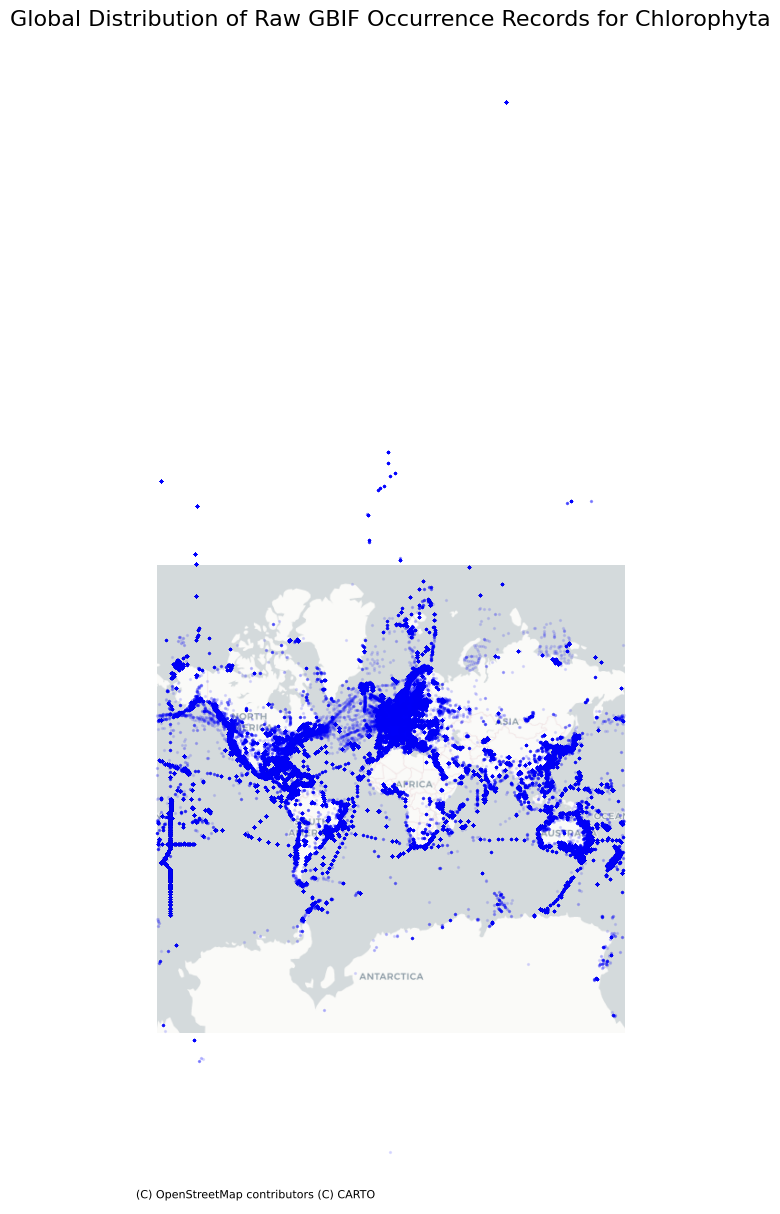

In [ ]:
# Convert the pandas DataFrame to a GeoDataFrame for spatial analysis
raw_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude),
    crs="EPSG:4326" # WGS84 coordinate system
)

# Plot the raw points with a web map basemap
fig, ax = plt.subplots(figsize=(15, 15))
# First convert the data's coordinate system to Web Mercator (EPSG:3857), which is the standard for web maps like the one added here.
raw_gdf.to_crs(epsg=3857).plot(ax=ax, marker='o', color='blue', markersize=2, alpha=0.1)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('Global Distribution of Raw GBIF Occurrence Records for Chlorophyta', fontsize=16)
plt.show()

### 1.3. Spatial Thinning to Reduce Sampling Bias
To mitigate the sampling bias as seen above, we perform spatial thinning (or rarefaction). This process creates a grid over the world and keeps only one randomly selected point within each grid cell. This ensures that our final dataset is more evenly distributed geographically, giving a truer representation of the phylum's environmental niche.

In [ ]:
# Create grid cells of 0.5 x 0.5 degrees and keep one record per cell
# Quick Note: The cell size is a key parameter that can be adjusted.
df['lon_cell'] = (df['decimalLongitude'] // 0.5) * 0.5
df['lat_cell'] = (df['decimalLatitude'] // 0.5) * 0.5
thinned_df = df.drop_duplicates(subset=['lon_cell', 'lat_cell'])
presence_df = thinned_df[['decimalLongitude', 'decimalLatitude']].copy()
print(f"Records after spatial thinning: {len(presence_df)}")

Records after spatial thinning: 12736


### 1.4. Visualizing Thinned Occurrence Data
The thinned dataset is plotted to provide a "before and after" comparison, visually confirming the successful reduction of data clustering. This final, thinned dataset serves as the presence data for the models.

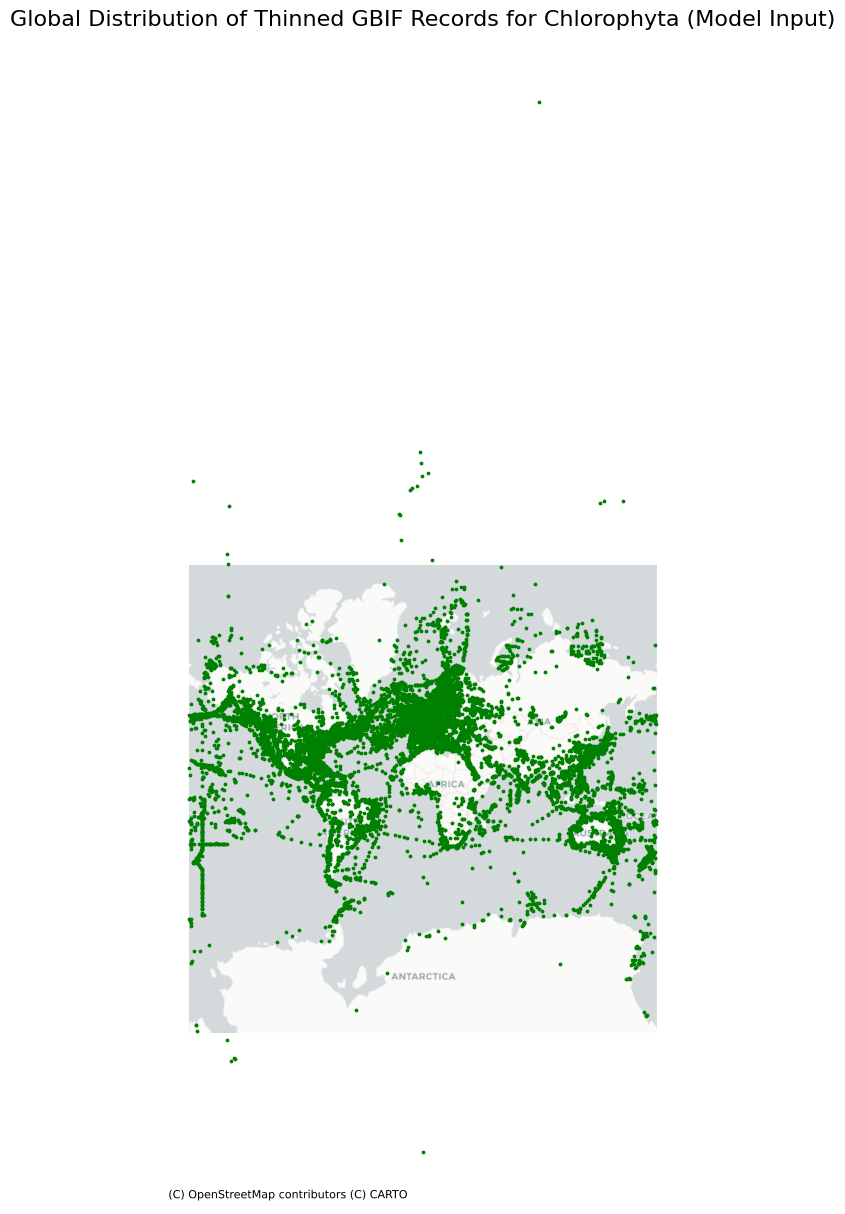

In [ ]:
# Convert the thinned DataFrame to the final presence GeoDataFrame
presence_gdf = gpd.GeoDataFrame(
    presence_df,
    geometry=gpd.points_from_xy(presence_df.decimalLongitude, presence_df.decimalLatitude),
    crs="EPSG:4326"
)

# Plot the thinned points with a web map basemap
fig, ax = plt.subplots(figsize=(15, 15))
# Convert to Web Mercator for plotting
presence_gdf.to_crs(epsg=3857).plot(ax=ax, marker='o', color='green', markersize=3)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('Global Distribution of Thinned GBIF Records for Chlorophyta (Model Input)', fontsize=16)
plt.show()

## **Part 2: Current Habitat Suitability Modeling**
**Objective:** To prepare the final dataset, train three distinct models, and rigorously evaluate their performance using a suite of validation metrics and plots.

### **2.1. Justifying Environmental Variable Selection**
A critical step in SDM is selecting predictor variables that are both ecologically relevant and statistically independent. And a two-stage process is used to select a final, independent set of predictor variables. An initial set of 6 ecologically relevant variables which was chosen is reduced to 3 by performing a multicollinearity analysis using a correlation matrix.

>***Initial Selection (19 down to 6):*** The WorldClim dataset provides 19 bioclimatic variables, many of which are highly correlated (e.g., Annual Mean Temperature and Mean Temperature of Warmest Quarter). <br>To avoid multicollinearity from the start and focus on key ecological drivers, an a priori selection of variables was performed based on established knowledge. We chose six variables to represent annual trends, seasonality, and extremes for both temperature and precipitation:<br> *`bio_1` (Annual Mean Temp), `bio_5` (Max Temp Warmest Month), `bio_6` (Min Temp Coldest Month), `bio_12` (Annual Precip), `bio_13` (Precip Wettest Month), and `bio_14` (Precip Driest Month).*

>***Final Selection (6 down to 3):*** To ensure statistical independence, a quantitative multicollinearity analysis was done. Values for the six variables at the presence locations were extracted and a correlation matrix was calculated. <br> Based on the standard practice of removing one variable from any pair with a high correlation coefficient (e.g., |r| > 0.8), the following decisions were made:<br> *`bio_1`, `bio_5`, and `bio_6` were all highly correlated with each other. `bio_1` was retained as it represents the central tendency of temperature.<br>
`bio_12` and `bio_13` were highly correlated. `bio_12` was retained as it represents the overall annual moisture availability.<br>
`bio_14` was not highly correlated with the other remaining variables, so it was retained as a measure of drought stress.*<br><br>
This resulted in a final set of three, relatively independent predictor variables: `['bio_1', 'bio_12', 'bio_14']`.

The code below performs this analysis and generates the correlation matrix plot that justifies the final selection.


--- Part 2: Model Preparation & Training ---
Extracting data for correlation analysis...


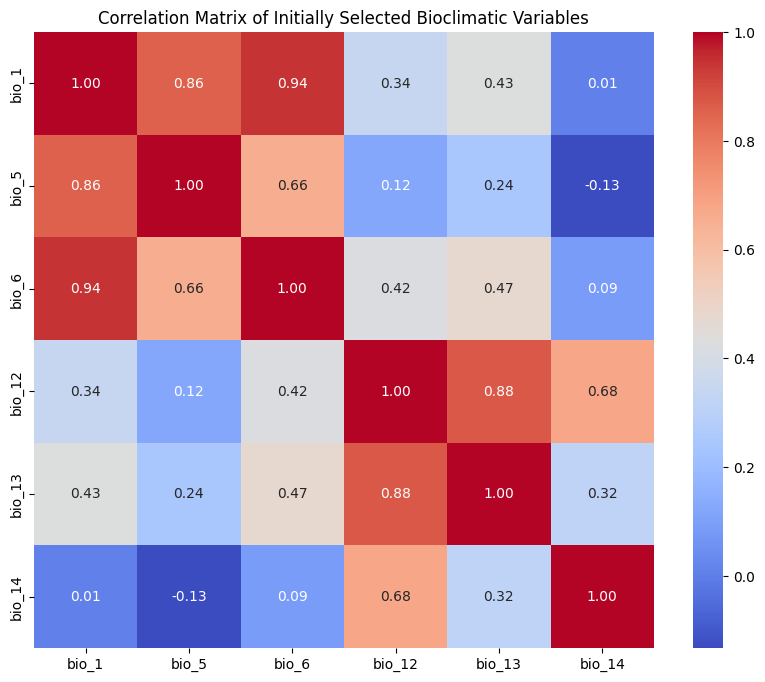

In [ ]:
print("\n--- Part 2: Model Preparation & Training ---")

# The six variables we initially considered
initial_vars = ['bio_1', 'bio_5', 'bio_6', 'bio_12', 'bio_13', 'bio_14']
current_climate_path = '/content/current_climate/'

# Prepare GeoDataFrame for analysis
corr_analysis_gdf = gpd.GeoDataFrame(
    presence_df,
    geometry=gpd.points_from_xy(presence_df.decimalLongitude, presence_df.decimalLatitude),
    crs="EPSG:4326"
)
corr_analysis_gdf.reset_index(drop=True, inplace=True)

# Extract climate data for the 6 variables at the thinned presence locations
x_coords = xr.DataArray(corr_analysis_gdf.geometry.x.values, dims="points")
y_coords = xr.DataArray(corr_analysis_gdf.geometry.y.values, dims="points")

print("Extracting data for correlation analysis...")
for var_name in initial_vars:
    file_path = f"{current_climate_path}wc2.1_2.5m_{var_name}.tif"
    with rioxarray.open_rasterio(file_path) as raster:
        nodata_val = raster.rio.nodata
        extracted_values = raster.sel(band=1, x=x_coords, y=y_coords, method="nearest")
        corr_analysis_gdf[var_name] = extracted_values.values
        if nodata_val is not None:
            corr_analysis_gdf[var_name] = corr_analysis_gdf[var_name].replace(nodata_val, np.nan)

# Drop points that fell on NoData cells
corr_analysis_gdf.dropna(inplace=True)

# Calculate and plot the correlation matrix to justify final variable choice
correlation_matrix = corr_analysis_gdf[initial_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Initially Selected Bioclimatic Variables')
plt.show()

### **2.2. Final Data Preparation for Modeling**
Background (pseudo-absence) points are generated and combined with the thinned presence data to create the final dataset for model training. This dataset is then split into training (70%) and testing (30%) sets

In [ ]:
# Define the final, non-correlated variables for modeling
final_vars = ['bio_1', 'bio_12', 'bio_14']

# Generate 10,000 random background points
print("Generating random background points...")
template_raster_path = f"{current_climate_path}wc2.1_2.5m_bio_1.tif"
with rioxarray.open_rasterio(template_raster_path) as template_raster:
    minx, miny, maxx, maxy = template_raster.rio.bounds()
num_background_points = 10000
bg_lon = np.random.uniform(minx, maxx, num_background_points)
bg_lat = np.random.uniform(miny, maxy, num_background_points)
background_df = pd.DataFrame({
    'decimalLongitude': bg_lon,
    'decimalLatitude': bg_lat
})

# Extract climate data for the 3 final variables at the background locations
bg_x_coords = xr.DataArray(background_df.decimalLongitude.values, dims="points")
bg_y_coords = xr.DataArray(background_df.decimalLatitude.values, dims="points")
print("Extracting climate data for background points...")
for var_name in final_vars:
    file_path = f"{current_climate_path}wc2.1_2.5m_{var_name}.tif"
    with rioxarray.open_rasterio(file_path) as raster:
        nodata_val = raster.rio.nodata
        extracted_values = raster.sel(band=1, x=bg_x_coords, y=bg_y_coords, method="nearest")
        background_df[var_name] = extracted_values.values
        if nodata_val is not None:
            background_df[var_name] = background_df[var_name].replace(nodata_val, np.nan)

# Drop points that fell in NoData areas
print(f"Background points before dropping NaNs: {len(background_df)}")
background_df.dropna(inplace=True)
print(f"Final valid background points: {len(background_df)}")


# Combine presence and background data
presence_final_df = corr_analysis_gdf[final_vars].copy()
presence_final_df['presence'] = 1
background_df['presence'] = 0
model_df = pd.concat([presence_final_df, background_df], ignore_index=True)
print(f"\nFull dataset created with {len(model_df)} total records.")

# Create Training and Testing Sets, stratified to handle class imbalance
X = model_df[final_vars]
y = model_df['presence']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Data successfully split into training and testing sets.")

Generating random background points...
Extracting climate data for background points...
Background points before dropping NaNs: 10000
Final valid background points: 3322

Full dataset created with 11093 total records.
Data successfully split into training and testing sets.


### **2.3. Model Training and Comparative Validation**
Three distinct models are trained on the same data and evaluated with the same metrics to provide a robust, comparative analysis.

#### **2.3.1. Random Forest**


--- Training & Validating Model 1: Random Forest ---
Model training complete.

Model AUC Score: 0.8449
Model TSS Score: 0.5247


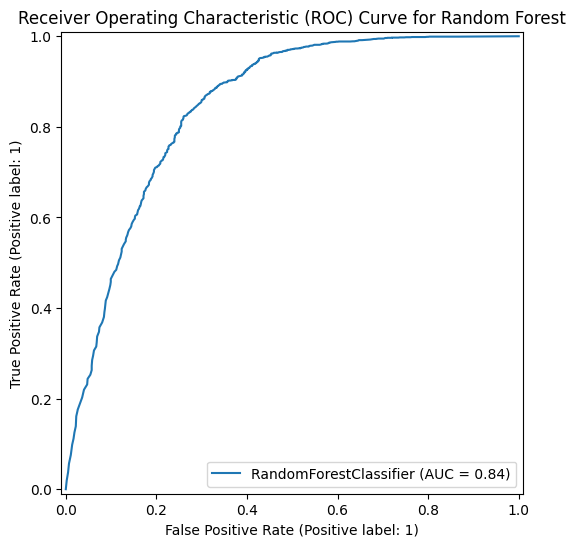

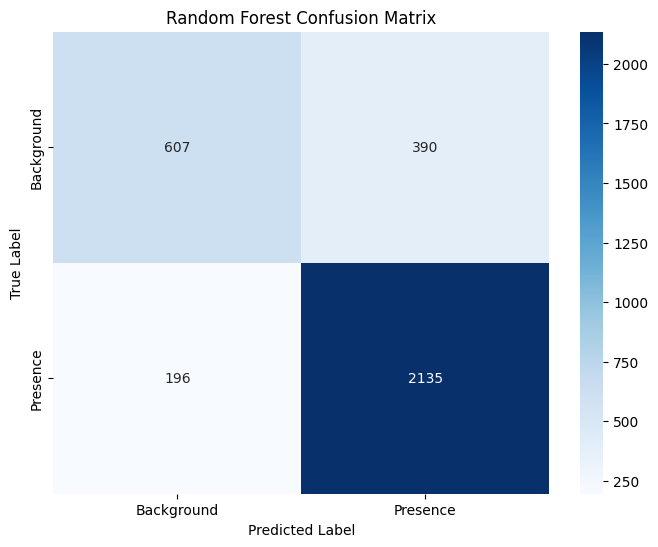

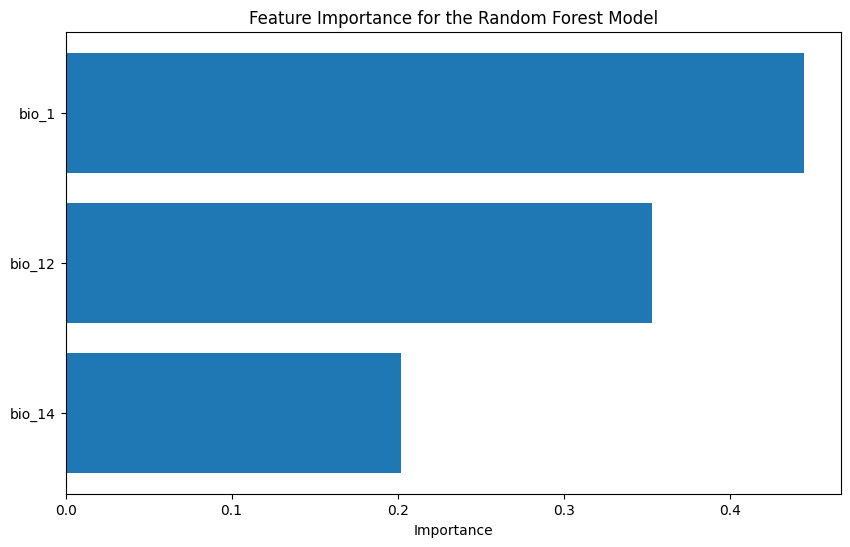

In [ ]:
print("\n--- Training & Validating Model 1: Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("Model training complete.")

# --- Predictions and High-Level Metrics ---
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nModel AUC Score: {auc:.4f}")
y_pred_class = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
tss = sensitivity + specificity - 1
print(f"Model TSS Score: {tss:.4f}")

# --- Validation Plots for Random Forest ---
# ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax)
ax.set_title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.show()

# Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Random Forest Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Background', 'Presence'])
ax.yaxis.set_ticklabels(['Background', 'Presence'])
plt.show()

# Variable Importance Bar Chart
importance_df = pd.DataFrame({
    'Variable': final_vars,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=True) # Ascending for horizontal bar plot

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['Variable'], importance_df['Importance'])
ax.set_title('Feature Importance for the Random Forest Model')
ax.set_xlabel('Importance')
plt.show()

#### **2.3.2. XGBoost**


--- Training & Validating Model 2: XGBoost ---
Model training complete.

XGBoost Model AUC Score: 0.8452
XGBoost Model TSS Score: 0.5398


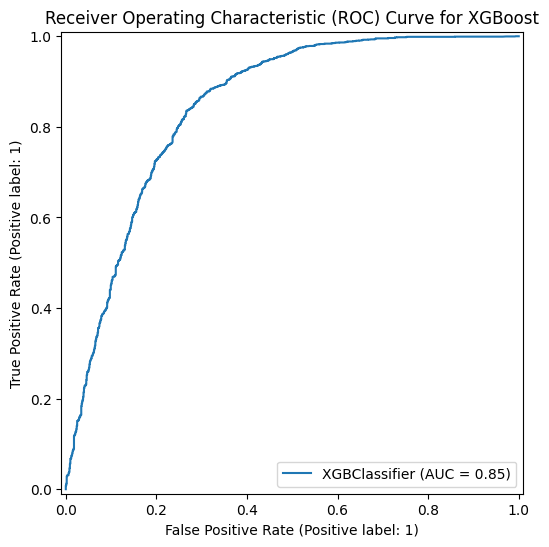

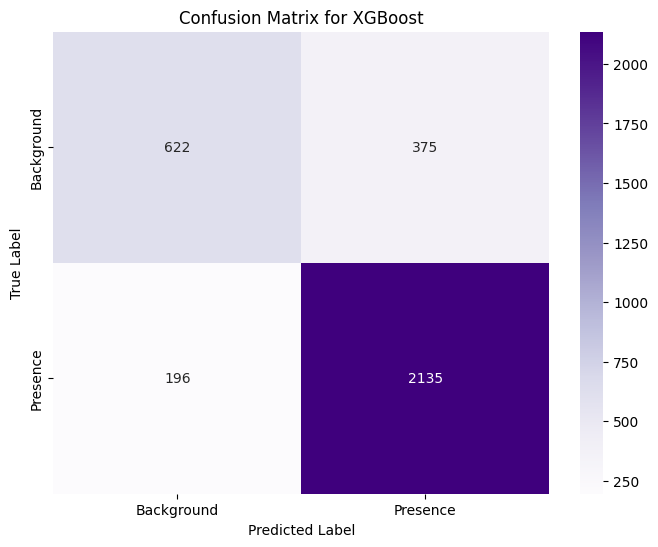

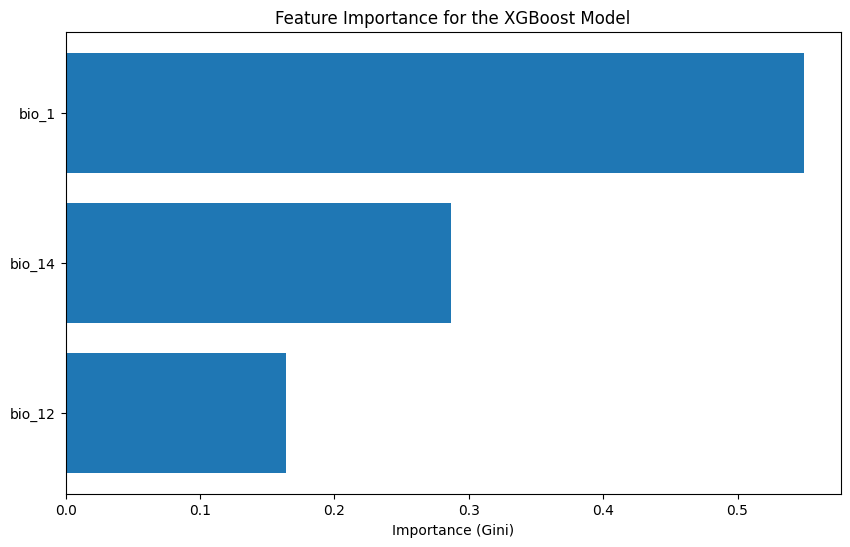

In [ ]:
print("\n--- Training & Validating Model 2: XGBoost ---")
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
print("Model training complete.")

# --- Predictions and High-Level Metrics ---
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"\nXGBoost Model AUC Score: {auc_xgb:.4f}")
y_pred_class_xgb = (y_pred_proba_xgb > 0.5).astype(int)
cm_xgb = confusion_matrix(y_test, y_pred_class_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()
sensitivity_xgb = tp_xgb / (tp_xgb + fn_xgb)
specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)
tss_xgb = sensitivity_xgb + specificity_xgb - 1
print(f"XGBoost Model TSS Score: {tss_xgb:.4f}")

# --- Validation Plots for XGBoost ---
# XGBoost ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax)
ax.set_title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.show()
# XGBoost Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples', ax=ax)
ax.set_title('Confusion Matrix for XGBoost')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Background', 'Presence'])
ax.yaxis.set_ticklabels(['Background', 'Presence'])
plt.show()

# XGBoost Variable Importance Bar Chart
importance_df_xgb = pd.DataFrame({
    'Variable': final_vars,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=True)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df_xgb['Variable'], importance_df_xgb['Importance'])
ax.set_title('Feature Importance for the XGBoost Model')
ax.set_xlabel('Importance (Gini)')
plt.show()

#### **2.3.3. Logistic Regression**


--- Training & Validating Model 3: Logistic Regression ---
Model training complete.

Logistic Regression Model AUC Score: 0.7956
Logistic Regression Model TSS Score: 0.4309


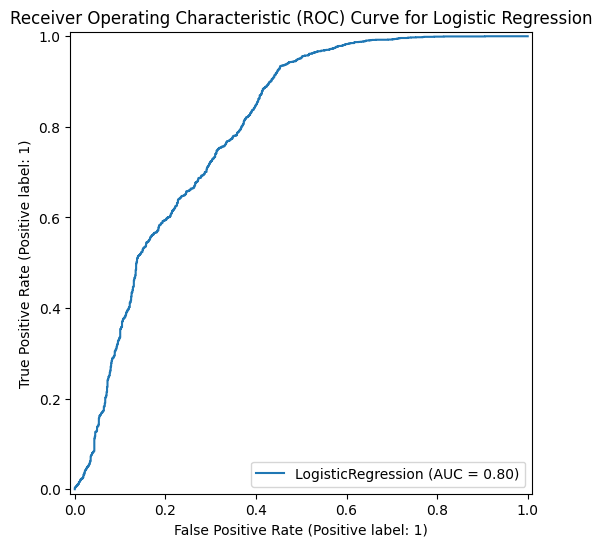

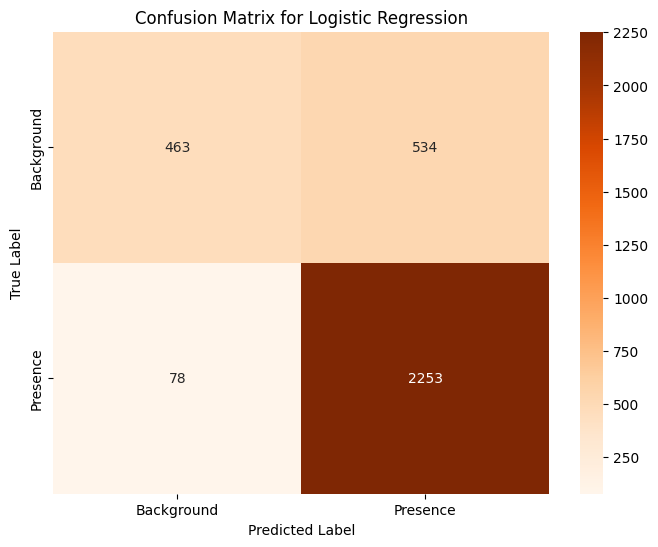

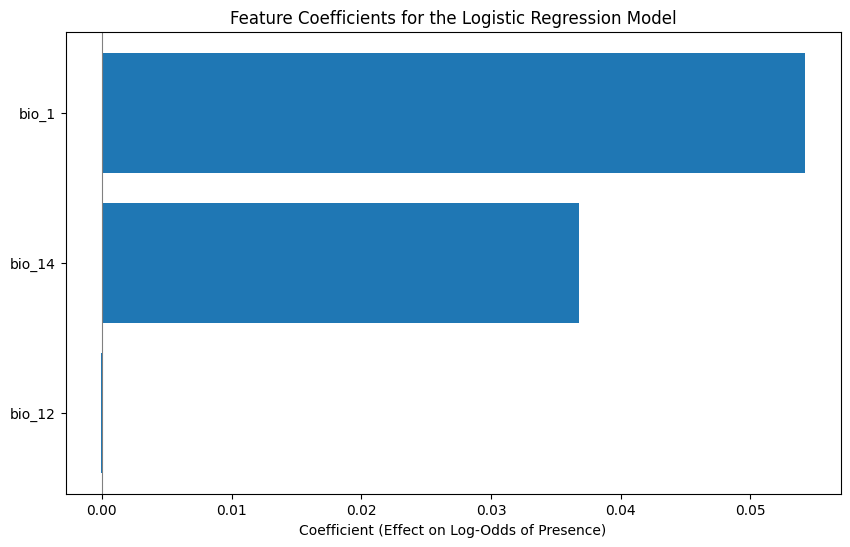

In [ ]:
print("\n--- Training & Validating Model 3: Logistic Regression ---")
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train, y_train)
print("Model training complete.")

# --- Predictions and High-Level Metrics ---
y_pred_proba_lr = log_reg_model.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"\nLogistic Regression Model AUC Score: {auc_lr:.4f}")
y_pred_class_lr = (y_pred_proba_lr > 0.5).astype(int)
cm_lr = confusion_matrix(y_test, y_pred_class_lr)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
sensitivity_lr = tp_lr / (tp_lr + fn_lr)
specificity_lr = tn_lr / (tn_lr + fp_lr)
tss_lr = sensitivity_lr + specificity_lr - 1
print(f"Logistic Regression Model TSS Score: {tss_lr:.4f}")

# --- Validation Plots for Logistic Regression ---
# Logistic Regression ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test, ax=ax)
ax.set_title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.show()

# Logistic Regression Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', ax=ax)
ax.set_title('Confusion Matrix for Logistic Regression')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(['Background', 'Presence'])
ax.yaxis.set_ticklabels(['Background', 'Presence'])
plt.show()

# Feature Importance (Coefficients)
# For linear models, we look at the coefficients, not Gini importance.
# The magnitude shows importance, and the sign shows the direction of the effect.
coefficients = log_reg_model.coef_[0]
importance_df_lr = pd.DataFrame({
    'Variable': final_vars,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=True)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df_lr['Variable'], importance_df_lr['Coefficient'])
ax.set_title('Feature Coefficients for the Logistic Regression Model')
ax.set_xlabel('Coefficient (Effect on Log-Odds of Presence)')
ax.axvline(0, color='grey', linewidth=0.8)
plt.show()

### 2.3

--- Final Model Performance Comparison ---
                        AUC     TSS
Model                              
Random Forest        0.8449  0.5247
XGBoost              0.8452  0.5398
Logistic Regression  0.7956  0.4309


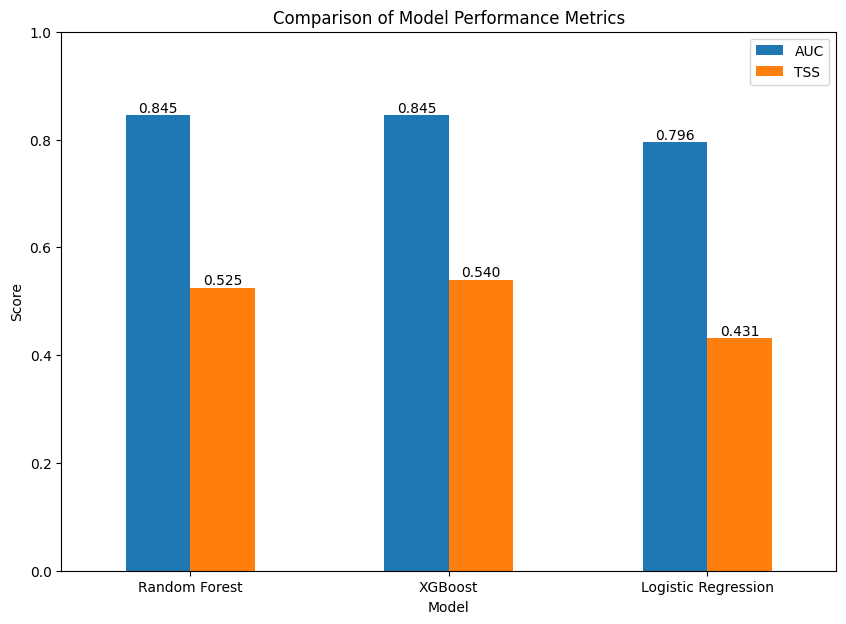

In [ ]:
# --- Final Model Performance Comparison Table ---
comparison_data = {
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression'],
    'AUC': [auc, auc_xgb, auc_lr],
    'TSS': [tss, tss_xgb, tss_lr]
}

# Create a pandas DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Model', inplace=True)
print("--- Final Model Performance Comparison ---")
print(comparison_df.round(4))

# --- Final Comparison Bar Plot ---
ax = comparison_df.plot(kind='bar', figsize=(10, 7), rot=0)
ax.set_ylabel("Score")
ax.set_title("Comparison of Model Performance Metrics")
ax.set_ylim(0, 1.0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')
plt.show()

## **Part 3: Future Projections and Change Analysis**
**Objective:** To use the best-performing model (Random Forest) to project habitat suitability onto current and future climate scenarios (SSP2-4.5 and SSP5-8.5) and to calculate the difference to identify "hotspots" of change.




### **3.1. Defining the Projection Functions**
First, the functions that will project the trained model (`rf_model`) onto the climate raster data is defined. Two versions are needed: one to handle the folder of separate GeoTIFFs for the current climate data, and a second, "multi-band" version to handle the single, stacked GeoTIFF files for the future climate data. Both functions include the critical step of writing the `NoData` value into the output file's metadata to ensure they display correctly in QGIS.

In [ ]:
# --- Function for the CURRENT climate data (separate files) ---
def project_model(model, climate_folder_path, variable_list, output_path):
    print(f"--- Starting projection for: {os.path.basename(climate_folder_path.rstrip('/'))} ---")
    ordered_raster_paths = []
    for var in variable_list:
        for f in os.listdir(climate_folder_path):
            if f"_{var}.tif" in f and f.endswith('.tif'):
                ordered_raster_paths.append(os.path.join(climate_folder_path, f))
                break
    climate_stack = xr.concat([rioxarray.open_rasterio(f) for f in ordered_raster_paths], dim="variable")
    template_raster = rioxarray.open_rasterio(ordered_raster_paths[0])
    pixel_data = climate_stack.to_numpy().reshape(len(variable_list), -1).T
    valid_data_mask = ~np.isnan(pixel_data).any(axis=1)
    print("Predicting habitat suitability...")
    suitability_predictions = np.full(pixel_data.shape[0], np.nan)
    suitability_predictions[valid_data_mask] = model.predict_proba(pixel_data[valid_data_mask])[:, 1]
    suitability_map = suitability_predictions.reshape(template_raster.shape[1], template_raster.shape[2])
    print(f"Saving output map to: {output_path}")
    output_raster = xr.DataArray(
        data=suitability_map.astype(np.float32),
        dims=("y", "x"),
        coords=dict(x=template_raster.x, y=template_raster.y),
    )
    output_raster.rio.write_crs(template_raster.rio.crs, inplace=True)
    output_raster.rio.write_nodata(np.nan, inplace=True)
    output_raster.rio.to_raster(output_path, tiled=True, compress='LZW')
    print(f"--- Projection complete for: {os.path.basename(climate_folder_path.rstrip('/'))} ---\n")

# --- Function for the FUTURE climate data (multi-band files) ---
def project_model_multiband(model, climate_file_path, variable_bands, output_path):
    print(f"--- Starting projection for: {os.path.basename(climate_file_path)} ---")
    with rioxarray.open_rasterio(climate_file_path) as raster:
        climate_stack = raster.sel(band=variable_bands)
    pixel_data = climate_stack.to_numpy().reshape(len(variable_bands), -1).T
    valid_data_mask = ~np.isnan(pixel_data).any(axis=1)
    print("Predicting habitat suitability...")
    suitability_predictions = np.full(pixel_data.shape[0], np.nan)
    suitability_predictions[valid_data_mask] = model.predict_proba(pixel_data[valid_data_mask])[:, 1]
    suitability_map = suitability_predictions.reshape(climate_stack.rio.height, climate_stack.rio.width)
    print(f"Saving output map to: {output_path}")
    output_raster = xr.DataArray(
        data=suitability_map.astype(np.float32),
        dims=("y", "x"),
        coords=dict(x=climate_stack.x, y=climate_stack.y),
    )
    output_raster.rio.write_crs(climate_stack.rio.crs, inplace=True)
    output_raster.rio.write_nodata(np.nan, inplace=True)
    output_raster.rio.to_raster(output_path, tiled=True, compress='LZW')
    print(f"--- Projection complete for: {os.path.basename(climate_file_path)} ---\n")

### **3.2. Generating the Global Maps**
With the functions defined, this cell calls them to generate the three primary output maps: one for the current climate and two for the future scenarios using the best-performing model (Random Forest).

In [ ]:
# Define file paths (ensure these are correct)
output_dir = '/content/drive/MyDrive/Study x Research/Chloroglobe/outputs_fin'
os.makedirs(output_dir, exist_ok=True)
current_climate_folder = '/content/current_climate/'
future_ssp245_file = '/content/drive/MyDrive/Study x Research/Chloroglobe/Data/future_ssp245/ssp245_multiband.tif' # UPDATE THIS PATH
future_ssp585_file = '/content/drive/MyDrive/Study x Research/Chloroglobe/Data/future_ssp585/ssp585_multiband.tif' # UPDATE THIS PATH

# Define output file names
current_map_path = os.path.join(output_dir, 'chlorophyta_suitability_current.tif')
future_ssp245_map_path = os.path.join(output_dir, 'chlorophyta_suitability_ssp245_2050.tif')
future_ssp585_map_path = os.path.join(output_dir, 'chlorophyta_suitability_ssp585_2050.tif')
# The variable names and band numbers our model needs
final_vars = ['bio_1', 'bio_12', 'bio_14']
model_bands = [1, 12, 14]

# Run the projections
print("Starting all map projections. This may take several minutes...")
project_model(rf_model, current_climate_folder, final_vars, current_map_path) # Project for Current Climate
project_model_multiband(rf_model, future_ssp245_file, model_bands, future_ssp245_map_path) # Project for Future SSP2-4.5
project_model_multiband(rf_model, future_ssp585_file, model_bands, future_ssp585_map_path) # Project for Future SSP5-8.5
print("All projections have been completed and saved!")

Starting all map projections. This may take several minutes...
--- Starting projection for: current_climate ---
Predicting habitat suitability...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Saving output map to: /content/drive/MyDrive/Study x Research/Chloroglobe/outputs_fin/chlorophyta_suitability_current.tif
--- Projection complete for: current_climate ---

--- Starting projection for: ssp245_multiband.tif ---
Predicting habitat suitability...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Saving output map to: /content/drive/MyDrive/Study x Research/Chloroglobe/outputs_fin/chlorophyta_suitability_ssp245_2050.tif
--- Projection complete for: ssp245_multiband.tif ---

--- Starting projection for: ssp585_multiband.tif ---
Predicting habitat suitability...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Saving output map to: /content/drive/MyDrive/Study x Research/Chloroglobe/outputs_fin/chlorophyta_suitability_ssp585_2050.tif
--- Projection complete for: ssp585_multiband.tif ---

All projections have been completed and saved!


### **3.3. Visualizing the Suitability Maps**
Before calculating the change, we can preview the three generated suitability maps to visually inspect the results and the projected biogeographic shifts.

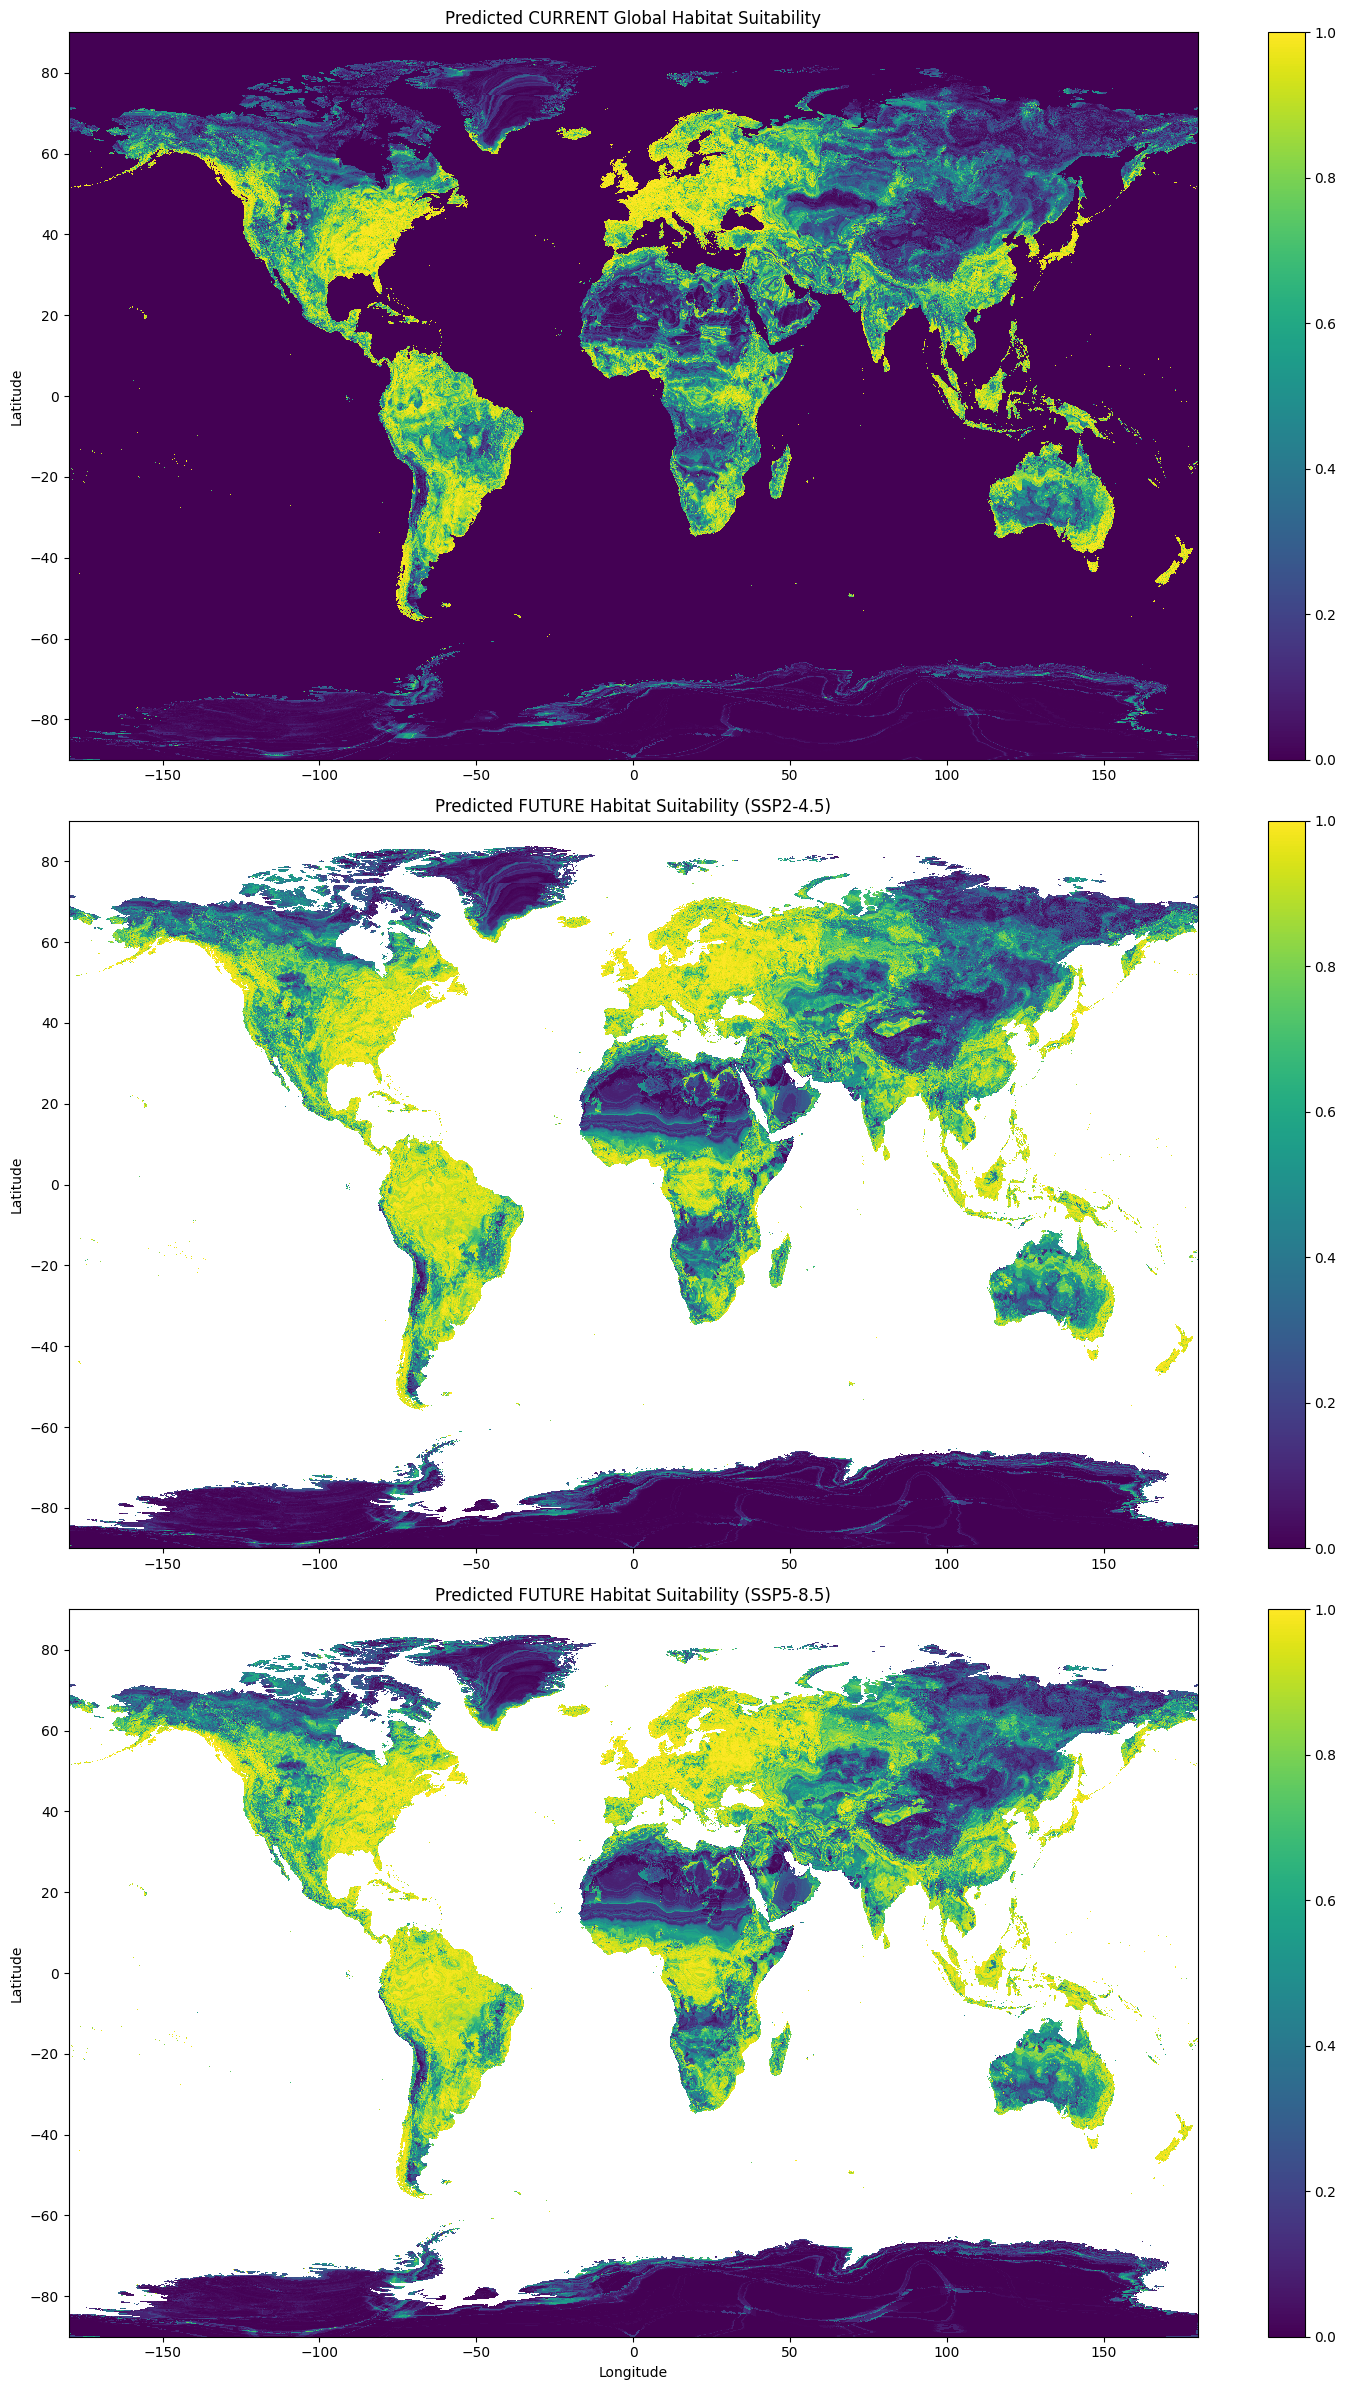

In [ ]:
# Visualize the Three Main Suitability Maps
# Load the generated maps
current_map_path = os.path.join(output_dir, 'chlorophyta_suitability_current.tif')
current_map = rioxarray.open_rasterio(current_map_path)
future_ssp245_map_path = os.path.join(output_dir, 'chlorophyta_suitability_ssp245_2050.tif')
ssp245_map = rioxarray.open_rasterio(future_ssp245_map_path)
future_ssp585_map_path = os.path.join(output_dir, 'chlorophyta_suitability_ssp585_2050.tif')
ssp585_map = rioxarray.open_rasterio(future_ssp585_map_path)

# Create three plots to see them together
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 24))

# Plot 1: Current
current_map.plot(ax=ax1, cmap='viridis', vmin=0, vmax=1)
ax1.set_title('Predicted CURRENT Global Habitat Suitability')
ax1.set_xlabel('')
ax1.set_ylabel('Latitude')

# Plot 2: SSP2-4.5
ssp245_map.plot(ax=ax2, cmap='viridis', vmin=0, vmax=1)
ax2.set_title('Predicted FUTURE Habitat Suitability (SSP2-4.5)')
ax2.set_xlabel('')
ax2.set_ylabel('Latitude')

# Plot 3: SSP5-8.5
ssp585_map.plot(ax=ax3, cmap='viridis', vmin=0, vmax=1)
ax3.set_title('Predicted FUTURE Habitat Suitability (SSP5-8.5)')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

### **3.4. Calculating and Previewing the Change Maps**
The final analytical step in the notebook is to calculate the difference between the future and current scenarios to produce "change maps" and to provide a final preview.

Calculating and saving change maps...
Change maps created and saved.


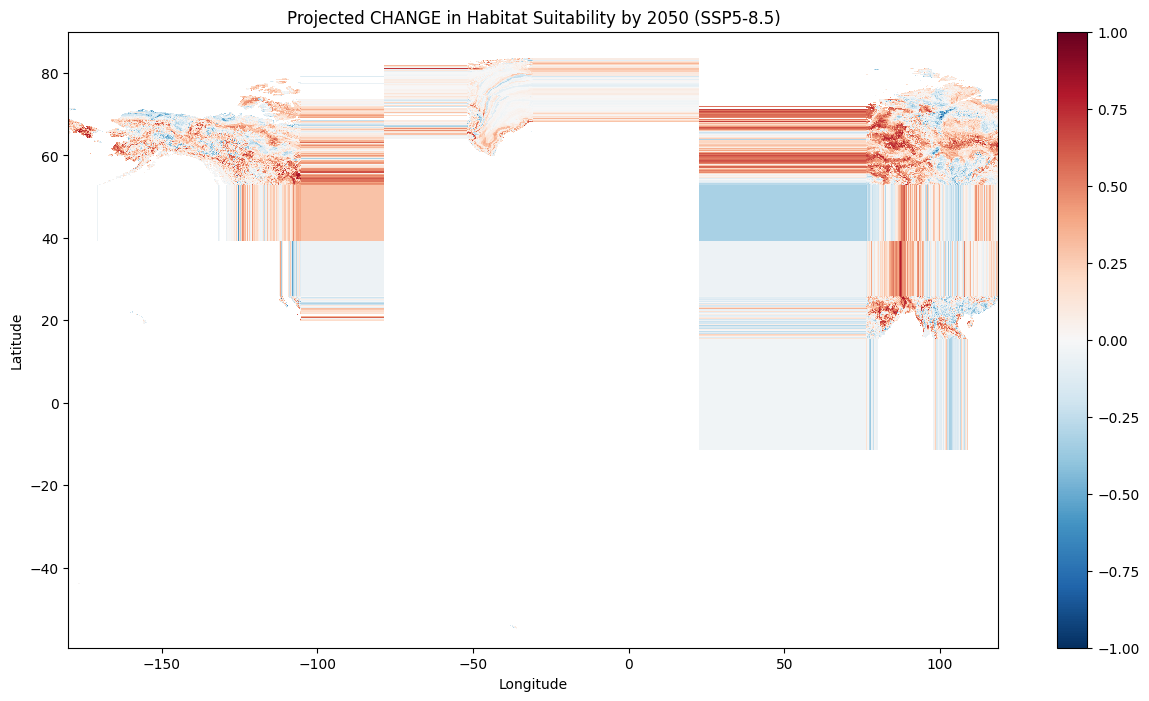

In [ ]:
# Calculate and save the change maps
print("Calculating and saving change maps...")
# --- Calculate Change (Future - Current) ---
change_ssp245 = ssp245_map - current_map
change_ssp585 = ssp585_map - current_map
change_ssp245_path = os.path.join(output_dir, 'change_map_ssp245.tif')
change_ssp585_path = os.path.join(output_dir, 'change_map_ssp585.tif')
change_ssp245.rio.to_raster(change_ssp245_path, tiled=True, compress='LZW')
change_ssp585.rio.to_raster(change_ssp585_path, tiled=True, compress='LZW')
print("Change maps created and saved.")

# Visualize the SSP5-8.5 change map in Colab for a preview
plt.figure(figsize=(15, 8))
change_ssp585.plot(cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Projected CHANGE in Habitat Suitability by 2050 (SSP5-8.5)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### **3.5. Final Note on Visualization**
As observed, the preview plot of the change map appears fragmented. This is not an error in the data but a limitation of the simple plotting tools within the notebook (`matplotlib` and `xarray`), which are not designed to be full-featured Geographic Information System  (GIS) programs. The final, correct maps are the GeoTIFF files (e.g., `change_map_ssp585.tif`) that were saved to Google Drive. For final cartographic production for the thesis report, the suitability map files has been exported to and styled in a dedicated GIS program called QGIS and the change map has been created.

**Thanks** 🙏